In [38]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [39]:
data = pd.read_csv("HW1.csv")
# data = pd.concat(map(pd.read_csv, ['HW1.csv', 'HW1_demo.csv']), ignore_index=True)
data

,song_popularity,song_duration_ms,acousticness,danceability,energy,instrumentalness,key,liveness,loudness,speechiness,tempo,audio_valence
0,73,262333,0.005520,0.496,0.682,0.000029,8,0.0589,-4.095,0.0294,167.060,0.474
1,66,216933,0.010300,0.542,0.853,0.000000,3,0.1080,-6.407,0.0498,105.256,0.370
2,76,231733,0.008170,0.737,0.463,0.447000,0,0.2550,-7.828,0.0792,123.881,0.324
3,74,216933,0.026400,0.451,0.970,0.003550,0,0.1020,-4.938,0.1070,122.444,0.198
4,56,223826,0.000954,0.447,0.766,0.000000,10,0.1130,-5.065,0.0313,172.011,0.574
...,...,...,...,...,...,...,...,...,...,...,...,...
15812,78,245493,0.225000,0.600,0.663,0.000000,3,0.1190,-5.802,0.0477,121.070,0.286
15813,61,241693,0.634000,0.566,0.664,0.000000,4,0.1160,-5.303,0.0464,128.945,0.437
15814,48,213053,0.603000,0.679,0.540,0.000017,0,0.0905,-7.457,0.0260,81.971,0.449
15815,62,205048,0.037100,0.665,0.709,0.000000,11,0.3230,-3.643,0.0370,100.001,0.841


In [40]:
x_data, t_data = data.drop(columns="song_popularity"), data["song_popularity"]

In [41]:
t_train, t_test = t_data[:10000], t_data[10000:]
x_train_pre, x_test_pre = x_data[:10000], x_data[10000:]

In [42]:
"""
mean = np.sum(x, axis=0) / len(x)
diff = (x - mean) ** 2
std = np.sqrt(np.sum(diff, axis=0) / (len(x) - 1))
"""

x_train = x_train_pre.apply(lambda x: (x - np.mean(x)) / np.std(x), axis=0)

In [43]:
x_test = x_test_pre.copy()
for column_header in x_test_pre.columns:
    x_train_column = x_train_pre[column_header]
    mean, std = np.mean(x_train_column), np.std(x_train_column)
    x_test[column_header] = (x_test[column_header] - mean) / std

In [44]:
M_LIST = [5, 10, 15, 20, 25, 30]
S = 0.1

In [45]:
class LinearRegression:
    def __init__(self, M: int, s: float) -> None:
        self._M = M
        self._s = s

        self._weight: np.ndarray = []

    @staticmethod
    def sigmoid(a: np.ndarray) -> np.ndarray:
        return 1 / (1 + np.exp(-a))

    def mu(self, j: int) -> float:
        upper = 3 * (-self._M + 1 + 2 * (j - 1) * ((self._M - 1) / (self._M - 2)))

        return upper / self._M

    def build_design_vector(self, x_vec: np.ndarray, j: int):
        return (
            LinearRegression.sigmoid((x_vec - self.mu(j)) / self._s)
            if j != 0
            else np.ones(len(x_vec))
        )

    def build_design_matrix(self, x_attr_vec: np.ndarray):
        return np.array(
            [self.build_design_vector(x_attr_vec, j) for j in range(self._M)]
        ).T

    def build_large_design_matrix(self, x_attr_matrix: np.ndarray):
        return np.hstack(
            [self.build_design_matrix(x_attr_vec) for x_attr_vec in x_attr_matrix.T]
        )

    def fit(self, x_train: np.ndarray, t_train):
        large_design_matrix = self.build_large_design_matrix(x_train)

        # large_design_matrix_T = large_design_matrix.T
        # a_matrix = large_design_matrix_T @ large_design_matrix
        # self._weight = np.linalg.pinv(a_matrix) @ large_design_matrix_T @ y_train

        self._weight = np.linalg.pinv(large_design_matrix) @ t_train
        return self._weight

    def prediction(self, x: np.ndarray):
        return self.build_large_design_matrix(x) @ self._weight

    def __str__(self):
        return f"M: {self._M}, s: {self._s}, weight shape: {len(self._weight)}"

In [46]:
sample_df = pd.concat(
    [pd.concat([t_test, x_test], axis=1), pd.concat([t_train, x_train], axis=1)]
)

# Set a random seed for reproducibility
np.random.seed(20)
sample_df = sample_df.sample(n=8000)
sample_df = sample_df.sort_values(by="danceability").reset_index(drop=True)
# sample_df.to_csv("sample_x2.csv", index=False)

In [47]:
sample_y = sample_df["song_popularity"]
sample_x = sample_df.drop(columns="song_popularity")

1. Plot the fitting curve of x_3


In [48]:
model_dict_1 = {m: LinearRegression(M=m, s=S) for m in M_LIST}
model_dict_1_predict, weight_1 = dict(), dict()

for k, val in model_dict_1.items():
    weight_1[k] = val.fit(x_train=x_train.values, t_train=t_train.values)
    t_predict = val.prediction(sample_x.values)
    model_dict_1_predict |= {k: t_predict}

<Figure size 640x480 with 0 Axes>

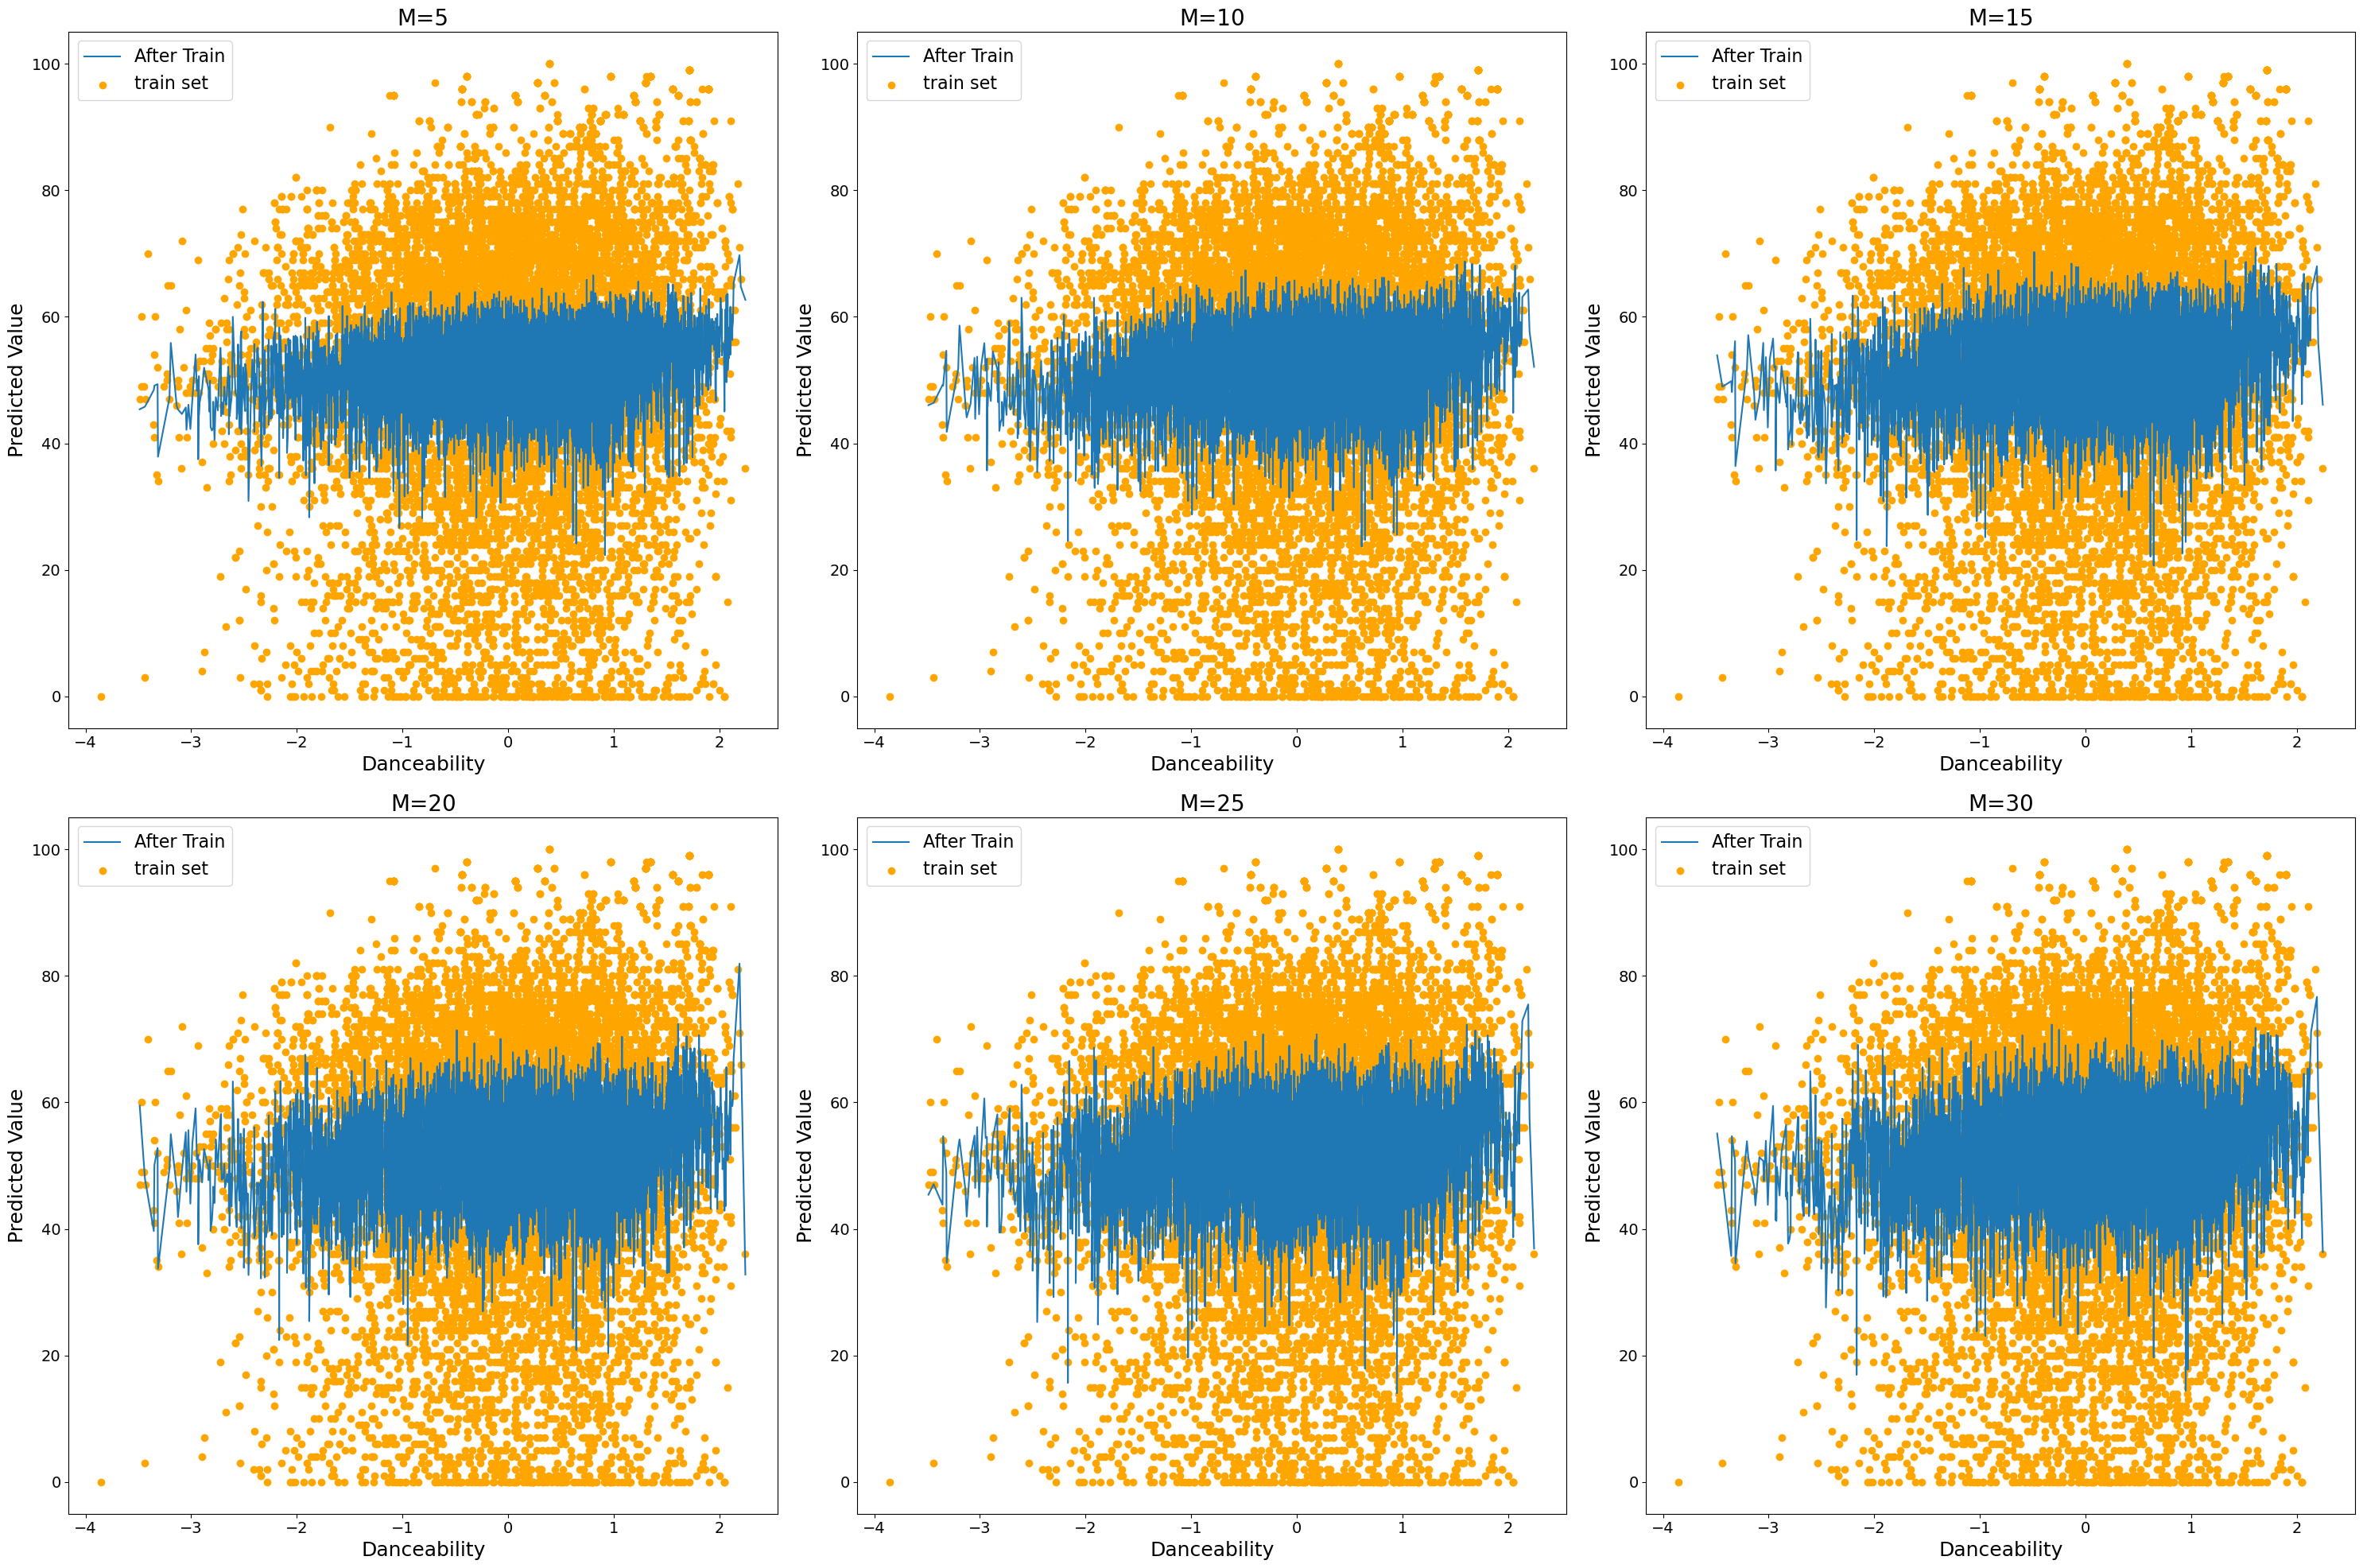

In [49]:
plt.clf()

figure, axis = plt.subplots(2, 3, figsize=(30, 20), tight_layout=True)

# Set font size
plt.rcParams.update({"font.size": 16})  # Set font size to 16

for index, (M, t_predict) in enumerate(model_dict_1_predict.items()):
    axis[index // 3, index % 3].set_title(f"M={M}", fontsize=20)  # Title font size

    axis[index // 3, index % 3].plot(
        sample_x["danceability"], t_predict, label="After Train"
    )

    axis[index // 3, index % 3].scatter(
        x_train["danceability"], t_train, label="train set", color="orange"
    )

    axis[index // 3, index % 3].legend()

    # Set x and y label font size
    axis[index // 3, index % 3].set_xlabel("Danceability", fontsize=18)
    axis[index // 3, index % 3].set_ylabel("Predicted Value", fontsize=18)

    # Set tick label font size
    axis[index // 3, index % 3].tick_params(axis="both", which="major", labelsize=14)

plt.show()

2. Plot MSE and evaluate accuracy


In [50]:
def accuracy(pred_set, true_set):
    denominator = true_set.copy()
    denominator[denominator == 0] = 1
    arr = (pred_set - true_set) / (denominator)
    return 1 - np.mean(np.abs(arr))


def mean_square_error(pred_set, true_set):
    return np.mean(np.square(pred_set - true_set))

In [51]:
model_dict_2 = {m: LinearRegression(M=m, s=S) for m in M_LIST}
for m in model_dict_2.keys():
    model_dict_2[m].fit(x_train=x_train.values, t_train=t_train.values)

model_dict_2_train = {
    k: val.prediction(x_train.values) for k, val in model_dict_2.items()
}

model_dict_2_test = {
    k: val.prediction(x_test.values) for k, val in model_dict_2.items()
}

In [52]:
df_output_2 = pd.DataFrame()

model_train_MSE = {
    k: mean_square_error(pred_set=v, true_set=t_train)
    for k, v in model_dict_2_train.items()
}

model_test_MSE = {
    k: mean_square_error(pred_set=v, true_set=t_test)
    for k, v in model_dict_2_test.items()
}

model_train_ACC = {
    k: accuracy(pred_set=v, true_set=t_train) for k, v in model_dict_2_train.items()
}

model_test_ACC = {
    k: accuracy(pred_set=v, true_set=t_test) for k, v in model_dict_2_test.items()
}

df_output_2["MSE Train"] = pd.Series(model_train_MSE)
df_output_2["MSE Test"] = pd.Series(model_test_MSE)
df_output_2["Accuracy Train"] = pd.Series(model_train_ACC)
df_output_2["Accuracy Test"] = pd.Series(model_test_ACC)
df_output_2

,MSE Train,MSE Test,Accuracy Train,Accuracy Test
5,429.578708,459.530372,-0.647245,-0.960286
10,424.423331,456.079294,-0.636015,-0.958530
15,419.450193,459.085291,-0.616335,-0.955685
20,414.301267,498.588012,-0.598457,-0.959657
25,411.902346,577.906816,-0.596394,-0.964589
30,409.643821,417757.512829,-0.590839,-1.114912


<Figure size 640x480 with 0 Axes>

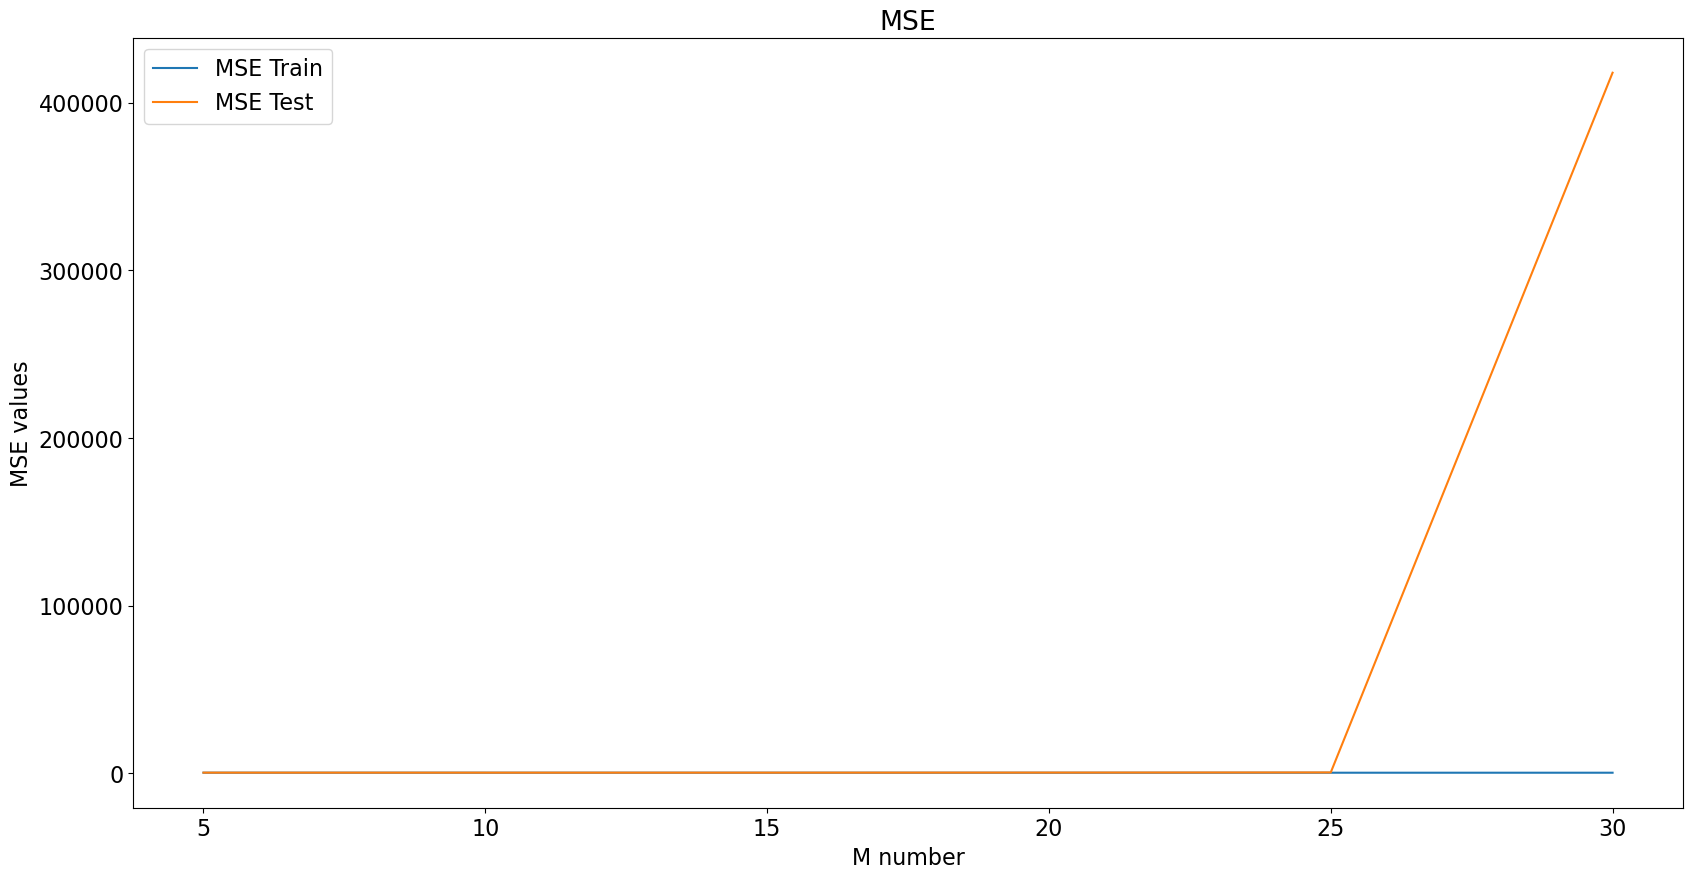

In [53]:
plt.clf()
plt.figure(figsize=(20, 10))
plt.plot(df_output_2.index, df_output_2["MSE Train"], label="MSE Train")

plt.plot(df_output_2.index, df_output_2["MSE Test"], label="MSE Test")

# plt.xticks(np.arange(3, 26, step=1))
# plt.xlim(4,26)
# plt.ylim(400, 575)

plt.title("MSE")
plt.xlabel("M number")
plt.ylabel("MSE values")
plt.legend()
plt.show()

3. 5-fold cross-validation, select the best order M and evaluate the MSE on the testing set


In [54]:
class CrossValidation:

    @staticmethod
    def split_data(number_split, x, t):
        if len(x) != len(t):
            return None
        return np.array_split(x, number_split), np.array_split(t, number_split)

    @staticmethod
    def merge_data(data_list, except_item_index):
        return np.concatenate(
            data_list[:except_item_index] + data_list[except_item_index + 1 :]
        )

    @staticmethod
    def mean_square_error(pred_set, true_set):
        return np.mean(np.square(pred_set - true_set))

    @staticmethod
    def k_cross_validation(
        model,
        training_function: str,
        predict_function: str,
        number_to_validation: int,
        x_data,
        t_data,
        x_test,
        t_test,
    ):
        x_train_term, t_train_term = CrossValidation.split_data(
            number_to_validation, x_data, t_data
        )

        error_list_train = []
        error_list_val = []
        error_list_test = []

        for i in range(number_to_validation):
            x_train_, x_val_ = (
                CrossValidation.merge_data(x_train_term, except_item_index=i),
                x_train_term[i],
            )

            t_train_, t_val_ = (
                CrossValidation.merge_data(t_train_term, except_item_index=i),
                t_train_term[i],
            )

            getattr(model, training_function)(x_train_, t_train_)

            model_train_t = getattr(model, predict_function)(x_train_)
            model_val_t = getattr(model, predict_function)(x_val_)
            model_test_t = getattr(model, predict_function)(x_test)

            error_list_train.append(
                CrossValidation.mean_square_error(
                    pred_set=model_train_t, true_set=t_train_
                )
            )
            error_list_val.append(
                CrossValidation.mean_square_error(pred_set=model_val_t, true_set=t_val_)
            )

            error_list_test.append(
                CrossValidation.mean_square_error(
                    pred_set=model_test_t, true_set=t_test
                )
            )

        return error_list_train, error_list_val, error_list_test

In [55]:
M_values = np.arange(5, 31, 1)

model_dict_3 = {
    m_test: CrossValidation.k_cross_validation(
        model=LinearRegression(M=m_test, s=S),
        training_function="fit",
        predict_function="prediction",
        number_to_validation=5,
        x_data=x_train.values,
        t_data=t_train.values,
        x_test=x_test.values,
        t_test=t_test.values,
    )
    for m_test in M_values
}

In [56]:
df_output_3 = pd.DataFrame()
mse_list_train, mse_list_val, mse_list_test = list(), list(), list()
var_list_train, var_list_val, var_list_test = list(), list(), list()
for k, (error_list_train, error_list_val, error_list_test) in model_dict_3.items():
    mse_list_train.append(np.mean(error_list_train))
    mse_list_val.append(np.mean(error_list_val))
    mse_list_test.append(np.mean(error_list_test))
    var_list_train.append(np.var(error_list_train))
    var_list_val.append(np.var(error_list_val))
    var_list_test.append(np.var(error_list_test))

# total_mean = [(x + y + z) / 3 for x, y, z in zip(mse_list_train, mse_list_val, mse_list_test)]
# total_var = [(x + y + z) / 3 for x, y, z in zip(var_list_train, var_list_val, var_list_test)]

# best_M_mean = np.argmin(total_mean)
# best_M_var = np.argmin(total_var)
# start_index, end_index = min(best_M_mean, best_M_var), max(best_M_mean, best_M_var) + 1
# best_M_index = np.argmin(mse_list_val[start_index: end_index])
# best_M_index += start_index

best_M_index = np.argmin(mse_list_val)

best_M = M_values[best_M_index]

print(f"Best M selected through cross-validation: {best_M}")

df_output_3["MSE Mean Train"] = pd.Series(mse_list_train, index=M_values)
df_output_3["MSE Mean Validation"] = pd.Series(mse_list_val, index=M_values)
df_output_3["MSE Mean Test"] = pd.Series(mse_list_test, index=M_values)
df_output_3["MSE Variance Train"] = pd.Series(var_list_train, index=M_values)
df_output_3["MSE Variance Validation"] = pd.Series(var_list_val, index=M_values)
df_output_3["MSE Variance Test"] = pd.Series(var_list_test, index=M_values)
# df_output_3.to_csv("df_output_3.csv", index=True)
df_output_3

Best M selected through cross-validation: 5


,MSE Mean Train,MSE Mean Validation,MSE Mean Test,MSE Variance Train,MSE Variance Validation,MSE Variance Test
5,427.079697,4.569289e+02,4.638825e+02,366.778888,5.041828e+03,6.406350e+01
6,427.045823,4.817596e+02,4.722969e+02,345.712783,8.667768e+03,3.819703e+02
7,422.234232,4.620898e+02,4.618644e+02,354.664378,4.614685e+03,9.546565e+01
8,422.321389,4.752071e+02,4.639995e+02,353.819037,4.319879e+03,1.298692e+02
9,421.464498,4.895312e+02,4.690968e+02,346.497839,5.515913e+03,2.069347e+02
10,421.079875,9.713356e+02,6.192329e+02,351.362772,8.504836e+05,9.067756e+04
11,419.583444,8.633691e+03,3.220589e+03,347.915754,2.575097e+08,3.001291e+07
12,418.152925,3.710209e+03,1.530646e+03,349.966820,3.367699e+07,4.136046e+06
13,417.179488,1.757881e+03,8.810128e+02,346.403543,5.285789e+06,6.019776e+05
14,416.507010,1.542087e+03,5.731642e+02,350.397971,3.914001e+06,1.272434e+04


<Figure size 640x480 with 0 Axes>

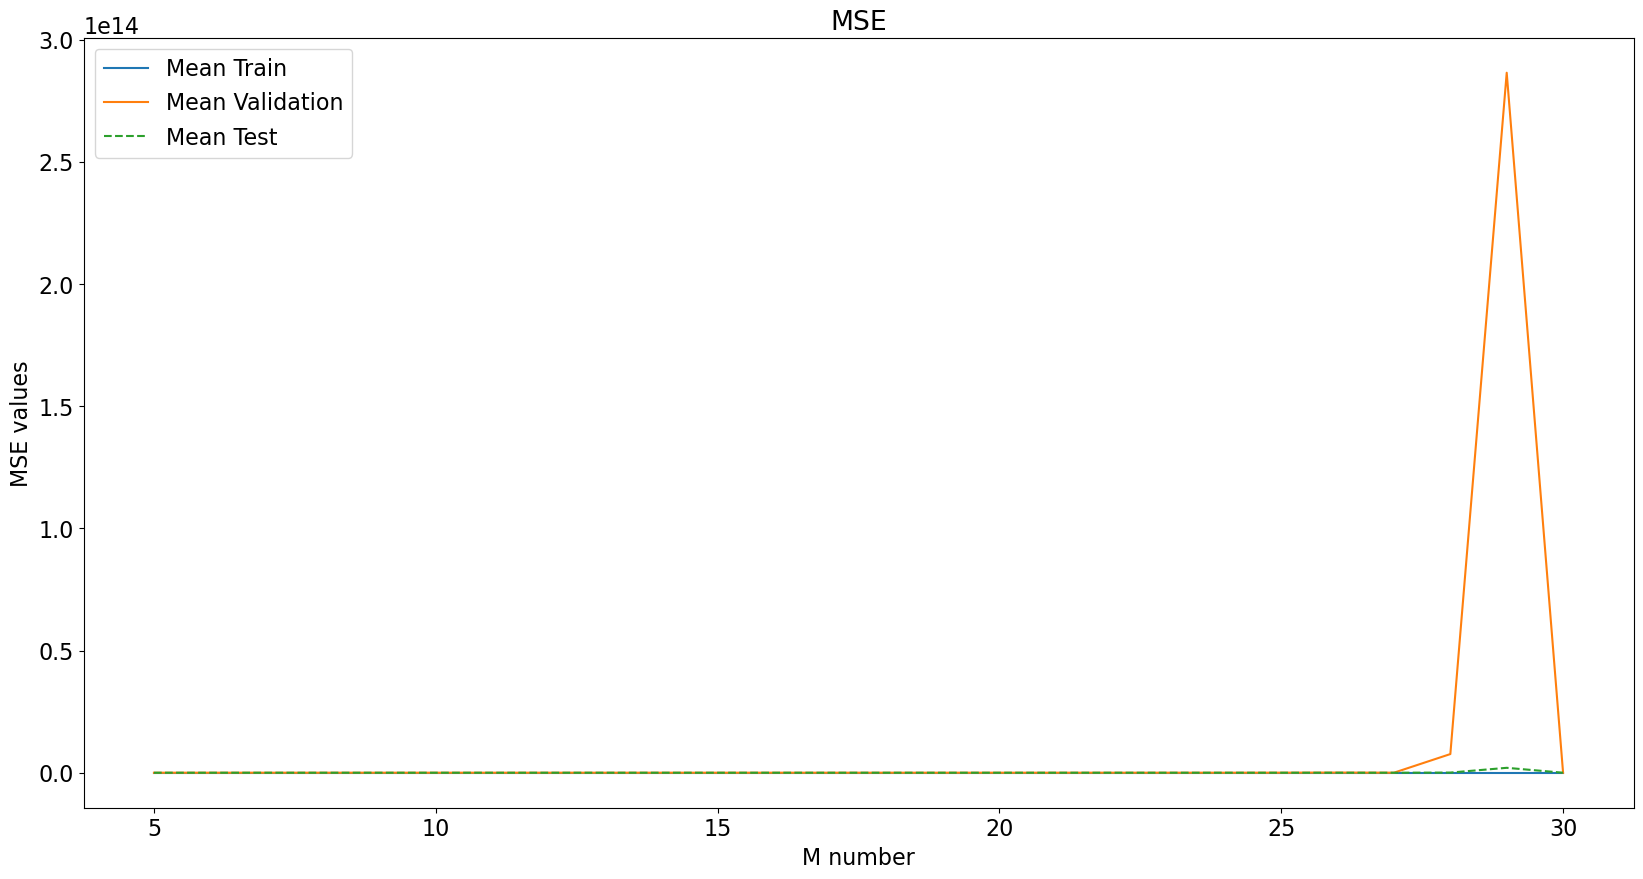

In [57]:
plt.clf()
plt.figure(figsize=(20, 10))
plt.plot(df_output_3.index, df_output_3["MSE Mean Train"], label="Mean Train")
plt.plot(df_output_3.index, df_output_3["MSE Mean Validation"], label="Mean Validation")
plt.plot(df_output_3.index, df_output_3["MSE Mean Test"], "--", label="Mean Test")
# plt.xticks(np.arange(5, 31))
# plt.ylim(-0.5e4, 1e7)
# plt.xlim(4.5, 18)
plt.title("MSE")
plt.xlabel("M number")
plt.ylabel("MSE values")
plt.legend()
plt.show()

<Figure size 640x480 with 0 Axes>

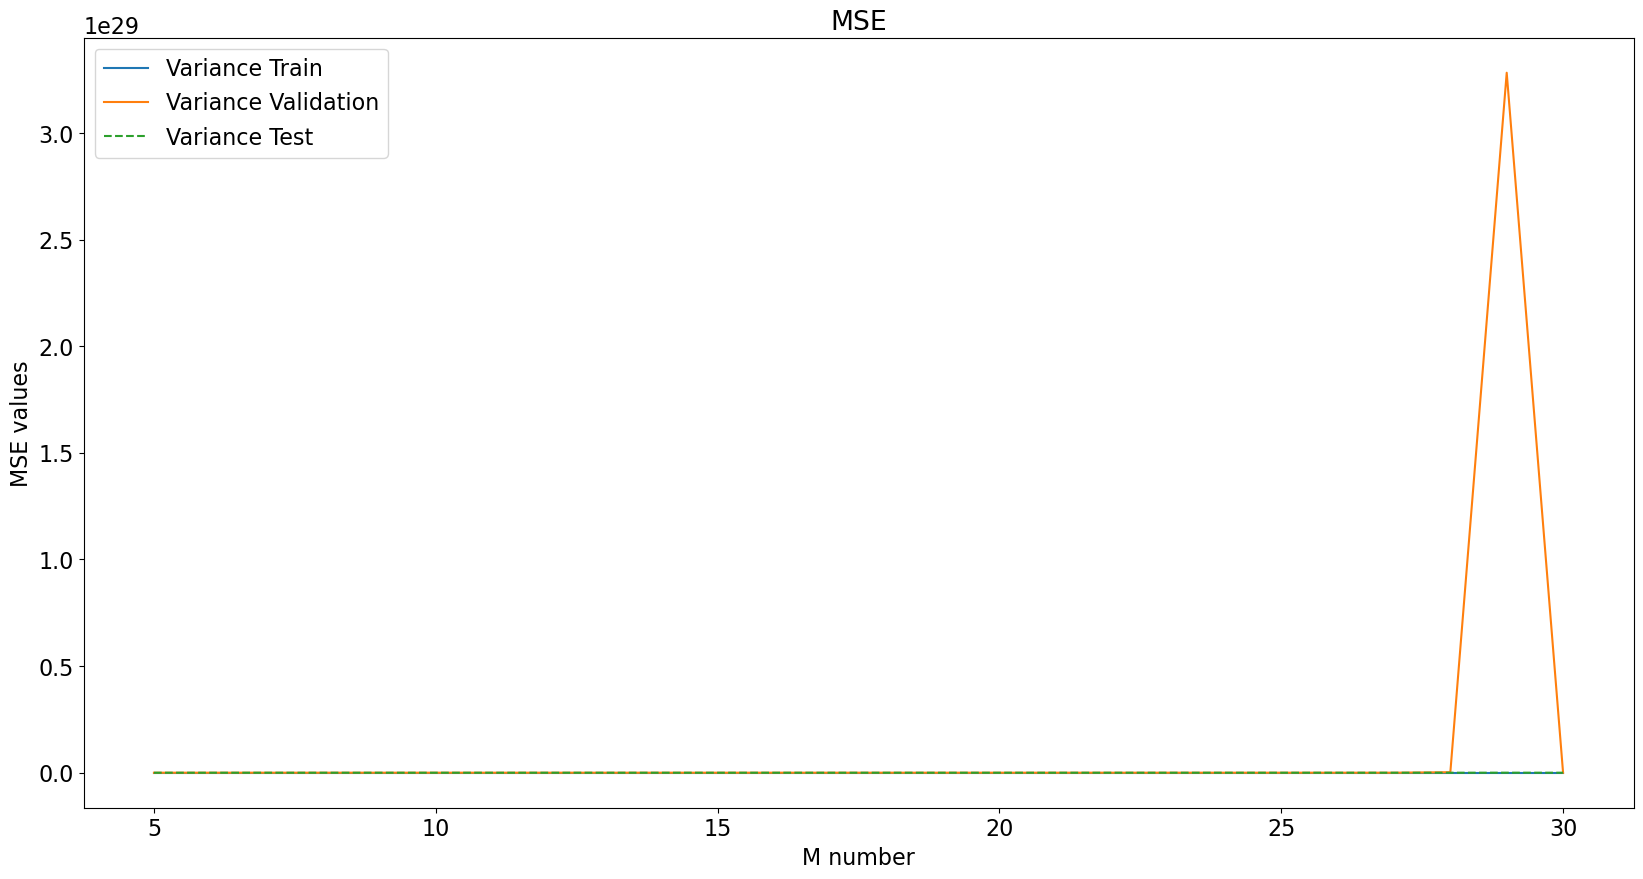

In [58]:
plt.clf()
plt.figure(figsize=(20, 10))
plt.plot(df_output_3.index, df_output_3["MSE Variance Train"], label="Variance Train")
plt.plot(
    df_output_3.index,
    df_output_3["MSE Variance Validation"],
    label="Variance Validation",
)
plt.plot(
    df_output_3.index, df_output_3["MSE Variance Test"], "--", label="Variance Test"
)
# plt.xticks(np.arange(5, 31))
# plt.ylim(1e1, 1e4)
# plt.xlim(6, 9)
plt.title("MSE")
plt.xlabel("M number")
plt.ylabel("MSE values")
plt.legend()
plt.show()

In [59]:
# Best M's MSE on testing set
best_m_model = LinearRegression(M=best_M, s=S)
weight = best_m_model.fit(x_train.values, t_train.values)
t_train_pred = best_m_model.prediction(x_train.values)
t_test_pred = best_m_model.prediction(x_test.values)
best_model_MSE_train = mean_square_error(pred_set=t_train_pred, true_set=t_train)
best_model_MSE_test = mean_square_error(pred_set=t_test_pred, true_set=t_test)

print(
    f"Best model using M = {best_M}, MSE train = {best_model_MSE_train}, MSE test = {best_model_MSE_test}"
)

Best model using M = 5, MSE train = 429.57870775222665, MSE test = 459.53037153028635


<Figure size 640x480 with 0 Axes>

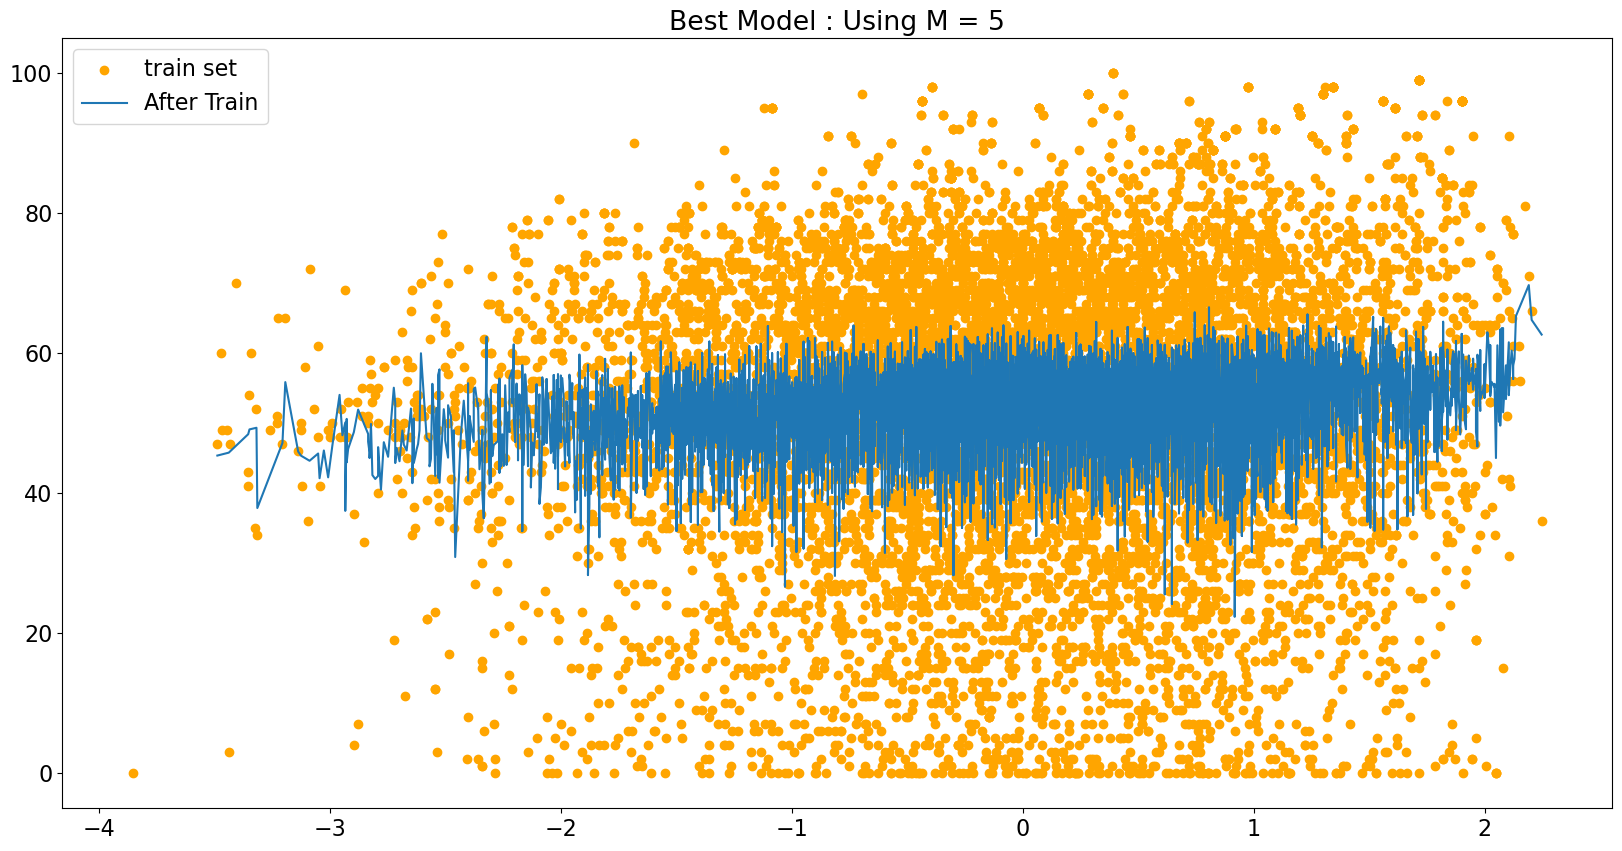

In [60]:
## plot the fitting curve x_3
t_pred = best_m_model.prediction(sample_x.values)
plt.clf()
plt.figure(figsize=(20, 10))
plt.scatter(x_train["danceability"], t_train, label="train set", color="orange")
plt.plot(sample_x["danceability"], t_pred, label="After Train")
plt.title(f"Best Model : Using M = {best_M}")
plt.legend()
plt.show()

4. Regularization


In [61]:
class RegularizationModel(LinearRegression):
    def __init__(self, M, s, lambda_param) -> None:
        super().__init__(M, s)
        self.lambda_param = lambda_param

    def fit(self, x_train: np.ndarray, t_train):
        large_design_matrix = self.build_large_design_matrix(x_train)

        a_matrix = large_design_matrix.T @ large_design_matrix

        self._weight = (
            np.linalg.inv(
                a_matrix + self.lambda_param * np.identity(large_design_matrix.shape[1])
            )
            @ large_design_matrix.T
            @ t_train
        )
        return self._weight

In [62]:
default_lambda = 1 / 10

model_dict_4 = {
    m: RegularizationModel(s=S, M=m, lambda_param=default_lambda) for m in M_LIST
}

model_dict_4_predict, weight_4 = dict(), dict()

for k, val in model_dict_4.items():
    weight_4[k] = val.fit(x_train.values, t_train.values)
    t_predict = val.prediction(sample_x.values)
    model_dict_4_predict |= {k: t_predict}

Part 1 with regularization


<Figure size 640x480 with 0 Axes>

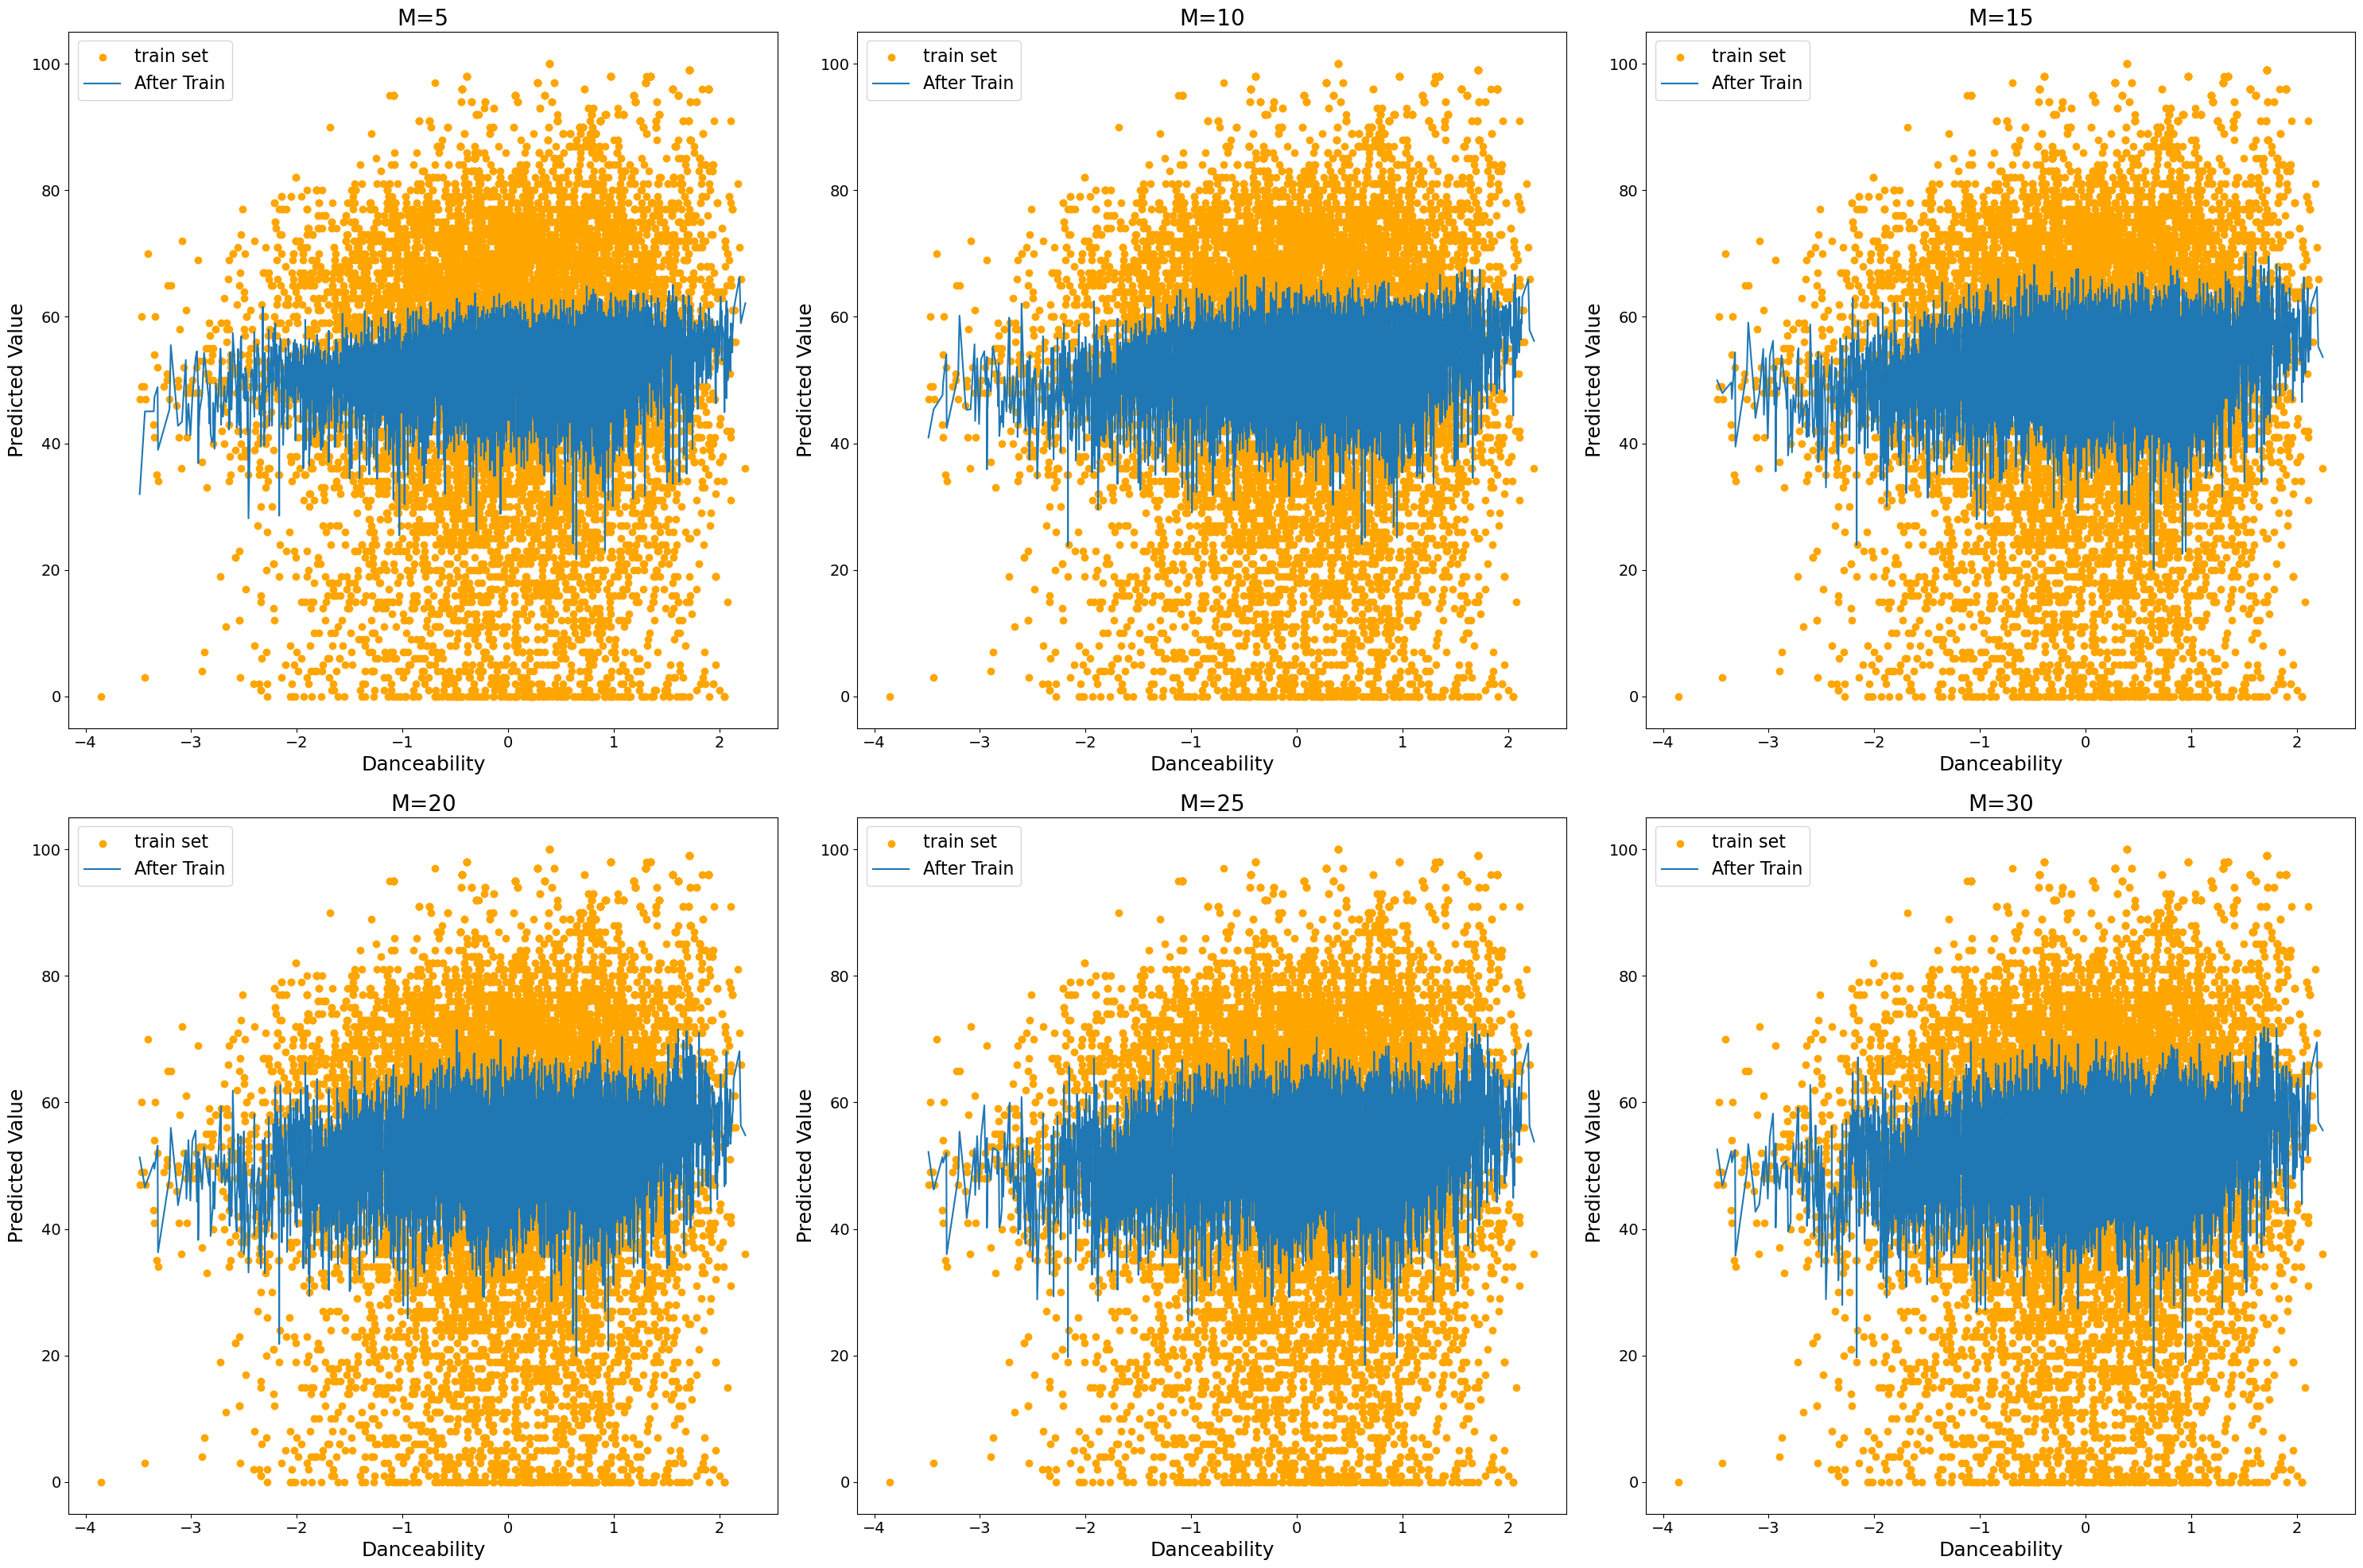

In [63]:
plt.clf()

figure, axis = plt.subplots(2, 3, figsize=(30, 20), tight_layout=True)
# Set font size
plt.rcParams.update({"font.size": 16})  # Set font size to 16

for index, (M, t_predict) in enumerate(model_dict_4_predict.items()):

    axis[index // 3, index % 3].set_title(f"M={M}", fontsize=20)
    axis[index // 3, index % 3].scatter(
        x_train["danceability"], t_train, label="train set", color="orange"
    )
    axis[index // 3, index % 3].plot(
        sample_x["danceability"], t_predict, label="After Train"
    )

    axis[index // 3, index % 3].legend()

    # Set x and y label font size
    axis[index // 3, index % 3].set_xlabel("Danceability", fontsize=18)
    axis[index // 3, index % 3].set_ylabel("Predicted Value", fontsize=18)

    # Set tick label font size
    axis[index // 3, index % 3].tick_params(axis="both", which="major", labelsize=14)

plt.show()

Part 2 with regularization


In [64]:
_model_regularization_dict = {
    m: RegularizationModel(s=S, M=m, lambda_param=default_lambda) for m in M_LIST
}
for m in _model_regularization_dict.keys():
    _model_regularization_dict[m].fit(x_train=x_train.values, t_train=t_train.values)

_model_regularization_dict_train = {
    k: val.prediction(x_train.values) for k, val in _model_regularization_dict.items()
}

_model_regularization_dict_test = {
    k: val.prediction(x_test.values) for k, val in _model_regularization_dict.items()
}

In [65]:
model_regularization_train_MSE = {
    k: mean_square_error(pred_set=v, true_set=t_train)
    for k, v in _model_regularization_dict_train.items()
}

model_regularization_test_MSE = {
    k: mean_square_error(pred_set=v, true_set=t_test)
    for k, v in _model_regularization_dict_test.items()
}

model_regularization_train_ACC = {
    k: accuracy(pred_set=v, true_set=t_train)
    for k, v in _model_regularization_dict_train.items()
}

model_regularization_test_ACC = {
    k: accuracy(pred_set=v, true_set=t_test)
    for k, v in _model_regularization_dict_test.items()
}

In [66]:
df_output_4 = pd.DataFrame()

df_output_4["Regularization MSE Train"] = pd.Series(model_regularization_train_MSE)
df_output_4["Regularization MSE Test"] = pd.Series(model_regularization_test_MSE)
df_output_4["Regularization Accuracy Train"] = pd.Series(model_regularization_train_ACC)
df_output_4["Regularization Accuracy Test"] = pd.Series(model_regularization_test_ACC)
df_output_4

,Regularization MSE Train,Regularization MSE Test,Regularization Accuracy Train,Regularization Accuracy Test
5,432.262153,463.100388,-0.653869,-0.974048
10,425.956477,457.275855,-0.639772,-0.964853
15,421.358836,458.179162,-0.624577,-0.959965
20,416.415203,461.361418,-0.607587,-0.959504
25,414.240288,461.504394,-0.604072,-0.963929
30,412.565178,461.923759,-0.601380,-0.962820


<Figure size 640x480 with 0 Axes>

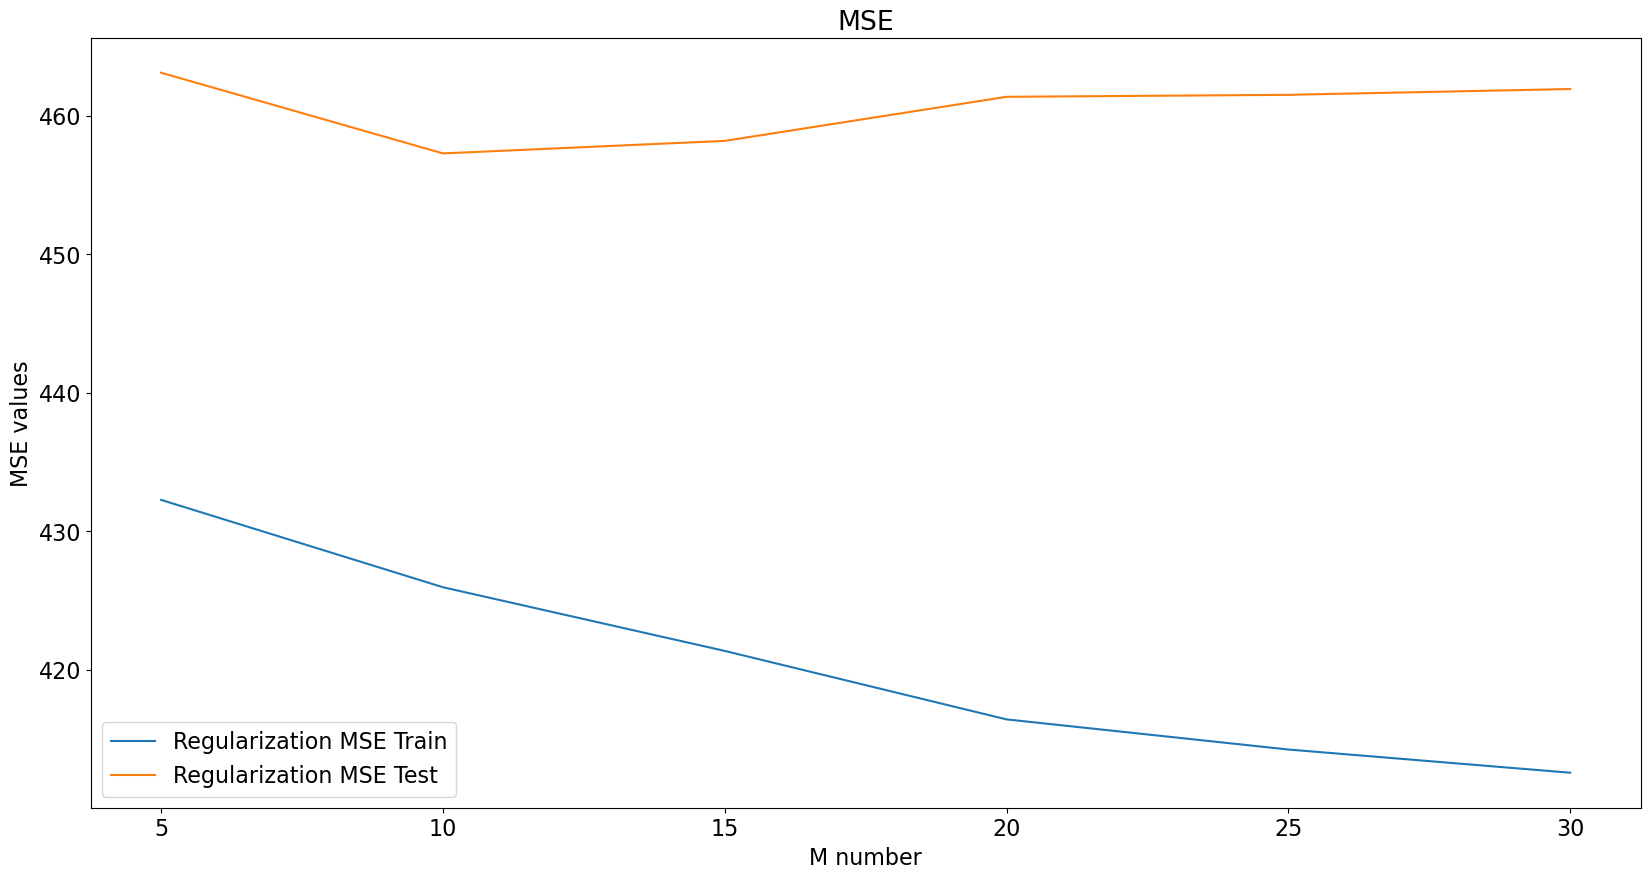

In [67]:
plt.clf()
plt.figure(figsize=(20, 10))
plt.plot(
    df_output_4.index,
    df_output_4["Regularization MSE Train"],
    label="Regularization MSE Train",
)

plt.plot(
    df_output_4.index,
    df_output_4["Regularization MSE Test"],
    label="Regularization MSE Test",
)

# plt.xticks(np.arange(3, 26, step=1))
# plt.xlim(3,26)
# plt.ylim(409, 800)

plt.title("MSE")
plt.xlabel("M number")
plt.ylabel("MSE values")
plt.legend()
plt.show()

Use different lambda


In [68]:
Lambda = [0.0001, 0.001, 0.01, 0.1, 1, 10]

model_dict_lambda = {
    l: RegularizationModel(s=S, M=best_M, lambda_param=l) for l in Lambda
}

model_dict_lambda_predict, weight_lambda = dict(), dict()

for k, val in model_dict_lambda.items():
    weight_lambda[k] = val.fit(x_train.values, t_train.values)
    t_predict = val.prediction(sample_x.values)

    model_dict_lambda_predict |= {k: t_predict}

In [69]:
for l in model_dict_lambda.keys():
    model_dict_lambda[l].fit(x_train=x_train.values, t_train=t_train.values)

_model_lambda_dict_train = {
    k: val.prediction(x_train.values) for k, val in model_dict_lambda.items()
}

_model_lambda_dict_test = {
    k: val.prediction(x_test.values) for k, val in model_dict_lambda.items()
}

In [70]:
model_lambda_train_MSE = {
    k: mean_square_error(pred_set=v, true_set=t_train)
    for k, v in _model_lambda_dict_train.items()
}

model_lambda_test_MSE = {
    k: mean_square_error(pred_set=v, true_set=t_test)
    for k, v in _model_lambda_dict_test.items()
}

model_lambda_train_ACC = {
    k: accuracy(pred_set=v, true_set=t_train)
    for k, v in _model_lambda_dict_train.items()
}

model_lambda_test_ACC = {
    k: accuracy(pred_set=v, true_set=t_test) for k, v in _model_lambda_dict_test.items()
}

<Figure size 640x480 with 0 Axes>

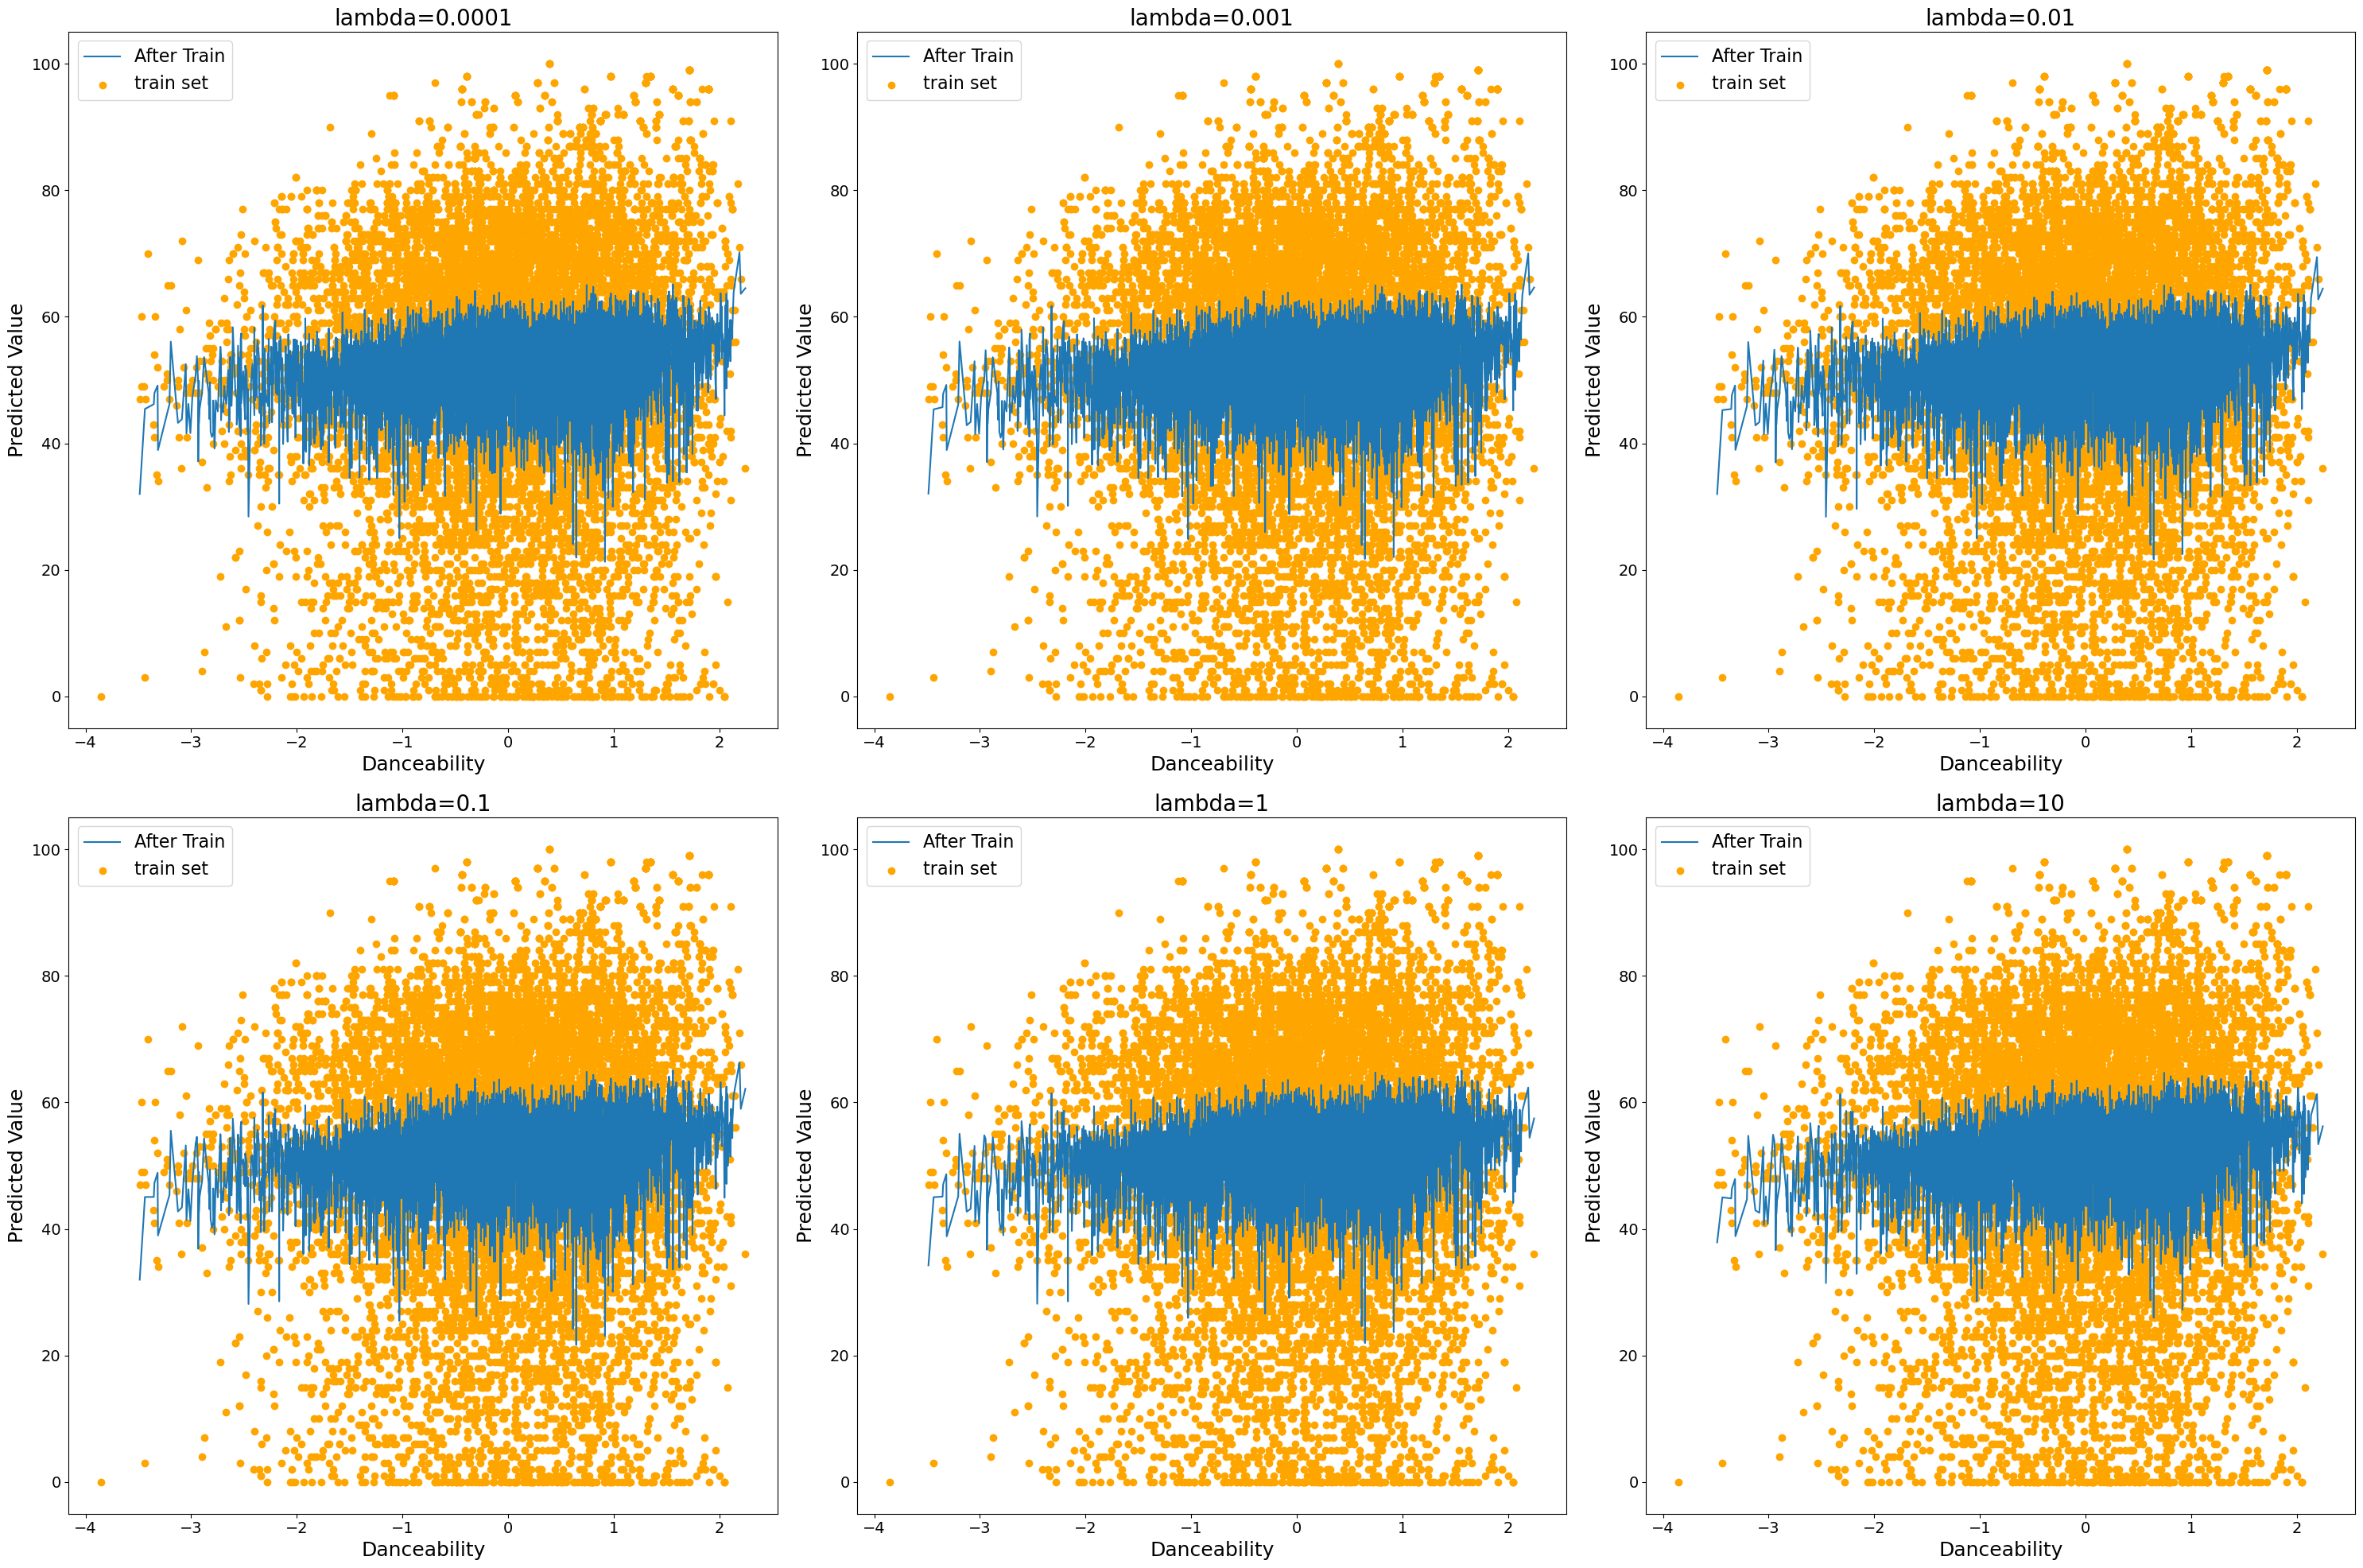

In [71]:
plt.clf()
figure, axis = plt.subplots(2, 3, figsize=(30, 20), tight_layout=True)

# Set font size
plt.rcParams.update({"font.size": 16})  # Set font size to 16

for index, (l, t_predict) in enumerate(model_dict_lambda_predict.items()):
    axis[index // 3, index % 3].set_title(f"lambda={l}", fontsize=20)  # Title font size

    axis[index // 3, index % 3].plot(
        sample_x["danceability"], t_predict, label="After Train"
    )

    axis[index // 3, index % 3].scatter(
        x_train["danceability"], t_train, label="train set", color="orange"
    )

    axis[index // 3, index % 3].legend()

    # Set x and y label font size
    axis[index // 3, index % 3].set_xlabel("Danceability", fontsize=18)
    axis[index // 3, index % 3].set_ylabel("Predicted Value", fontsize=18)

    # Set tick label font size
    axis[index // 3, index % 3].tick_params(axis="both", which="major", labelsize=14)

plt.show()

In [72]:
df_output_lambda = pd.DataFrame()

df_output_lambda["Regularization MSE Train"] = pd.Series(model_lambda_train_MSE)
df_output_lambda["Regularization MSE Test"] = pd.Series(model_lambda_test_MSE)
df_output_lambda["Regularization Accuracy Train"] = pd.Series(model_lambda_train_ACC)
df_output_lambda["Regularization Accuracy Test"] = pd.Series(model_lambda_test_ACC)
df_output_lambda

,Regularization MSE Train,Regularization MSE Test,Regularization Accuracy Train,Regularization Accuracy Test
0.0001,431.046020,461.371924,-0.650253,-0.969323
0.0010,431.326202,461.592088,-0.650455,-0.969920
0.0100,431.446598,461.814015,-0.651172,-0.970768
0.1000,432.262153,463.100388,-0.653869,-0.974048
1.0000,433.295878,464.215096,-0.656372,-0.976059
10.0000,433.591891,463.905792,-0.658331,-0.976170


<Figure size 640x480 with 0 Axes>

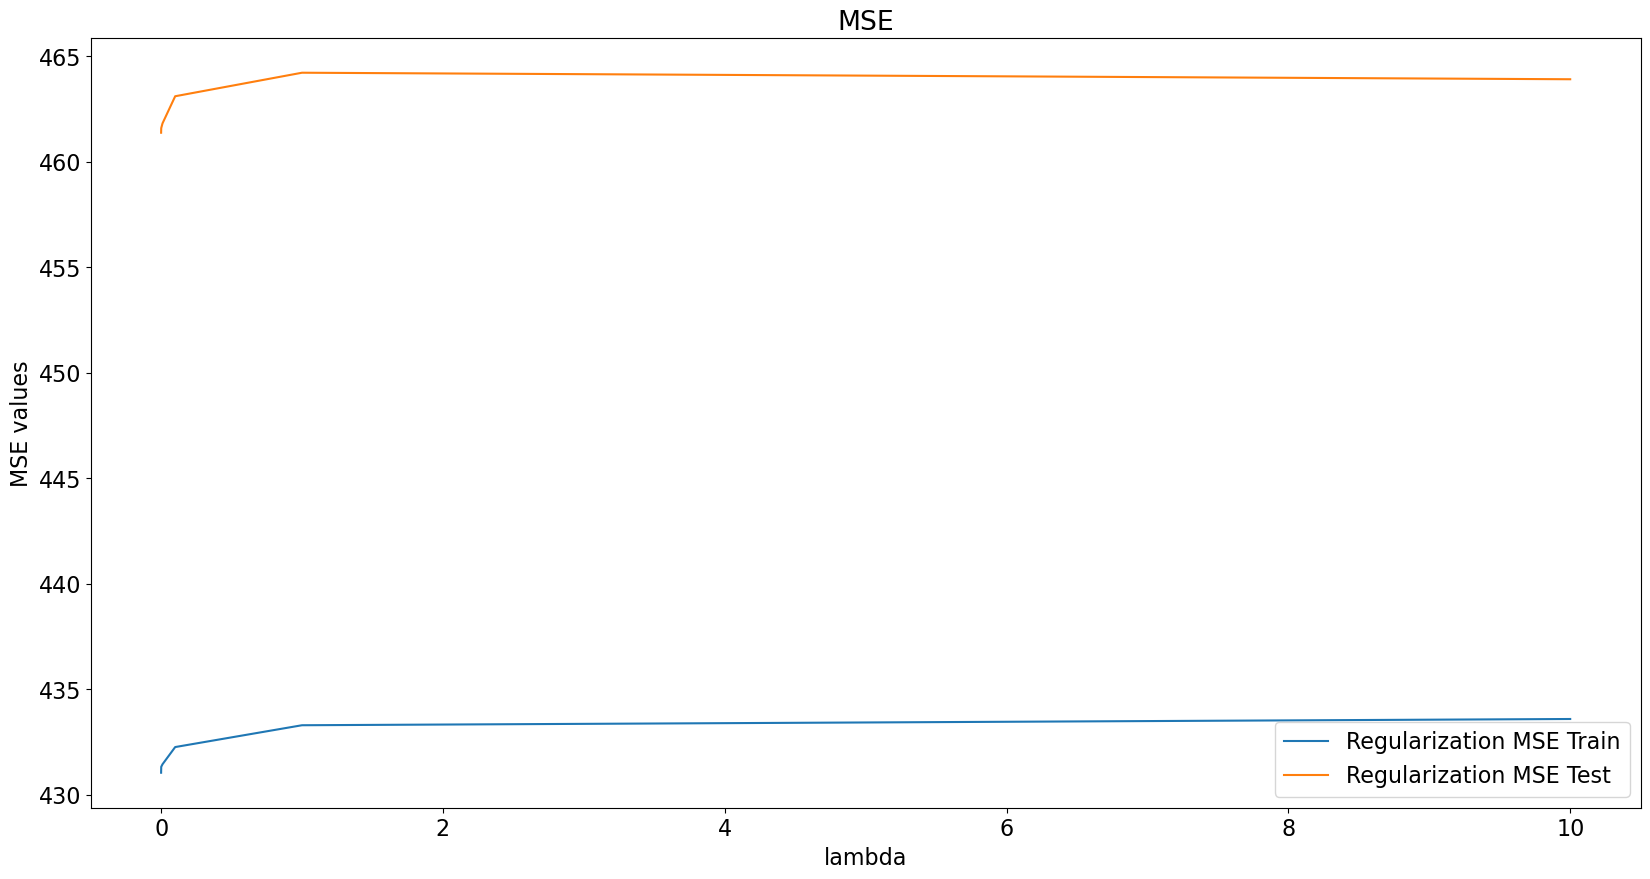

In [73]:
plt.clf()
plt.figure(figsize=(20, 10))
plt.plot(
    df_output_lambda.index,
    df_output_lambda["Regularization MSE Train"],
    label="Regularization MSE Train",
)

plt.plot(
    df_output_lambda.index,
    df_output_lambda["Regularization MSE Test"],
    label="Regularization MSE Test",
)

# plt.xticks(np.arange(3, 26, step=1))
# plt.xlim(3,26)
# plt.ylim(409, 800)

plt.title("MSE")
plt.xlabel("lambda")
plt.ylabel("MSE values")
plt.legend()
plt.show()